# Python packages

We need two packages for this workshop: Stim (https://github.com/quantumlib/Stim) and PyMatching (https://pymatching.readthedocs.io/en/stable/). You can install these packages with pip. Write the following commands into the terminal:

pip install stim

pip install pymatching



In [1]:
import stim
import numpy as np
import pymatching
import matplotlib.pyplot as plt

# 1. Stim basics

Stim is an efficient Clifford simulator. It can simulate large quantum circuits inluding only Clifford gates.

You can find the list of the available gates, errors and other instructions here: https://github.com/quantumlib/Stim/blob/main/doc/gates.md

In the following we show how to create a simple stim circuit that creates a Bell pair and then measures the qubits in the Z-basis. 

H 0
CX 0 1
M 0 1


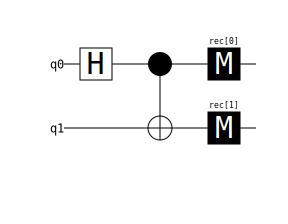

In [2]:
#Create the circuit
circuit = stim.Circuit()
#The number of qubits is unspecifed yet
#Every qubit is initialized in the |0> state

#Apply a Hadamard gate on the 0th qubit
circuit.append('H',0)

#Apply a CNOT between the 0th and first qubits (0 - control, 1 - target)
circuit.append('CNOT',[0,1])

#Measure the 0th and the first qubit in the Z-basis
circuit.append('M',[0,1])

#Print and draw the circuit
print(circuit)
circuit.diagram('timeline-svg')

In [3]:
#Create a sampler to sample the outcome distribution of this circuit
sampler = circuit.compile_sampler()

#Sample the circuit 10 time
outcome = sampler.sample(10)
print(outcome)
#False - measurement outcome = 1 (|0> state)
#True - measurement outcome = -1 (|1> state)

#The measurement outcomes are always the same. Let's show this
difference = [outcome[i][0] == outcome[i][1] for i in range(10)]
print(difference)

[[False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [False False]]
[np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]


In [4]:
#Now let's introduce some noise
noisy_circuit = stim.Circuit()
noisy_circuit.append('H',0)
noisy_circuit.append('CNOT',[0,1])

#X-errors on the qubits with 5% error rate
noisy_circuit.append('X_ERROR',[0,1],0.05)

noisy_circuit.append('M',[0,1])

noisy_sampler = noisy_circuit.compile_sampler()
outcome = noisy_sampler.sample(10)
difference = [outcome[i][0] == outcome[i][1] for i in range(10)]

#The measurement outcomes are not always the same anymore.
print(difference)

[np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.False_, np.True_]


# 2. Surface-17 code

In this task you implement a syndrome extraction circuit for the surface-17 code.

The layout of the surface-17 code is shown below.

![Alt Text](surface17_layout.jpg)

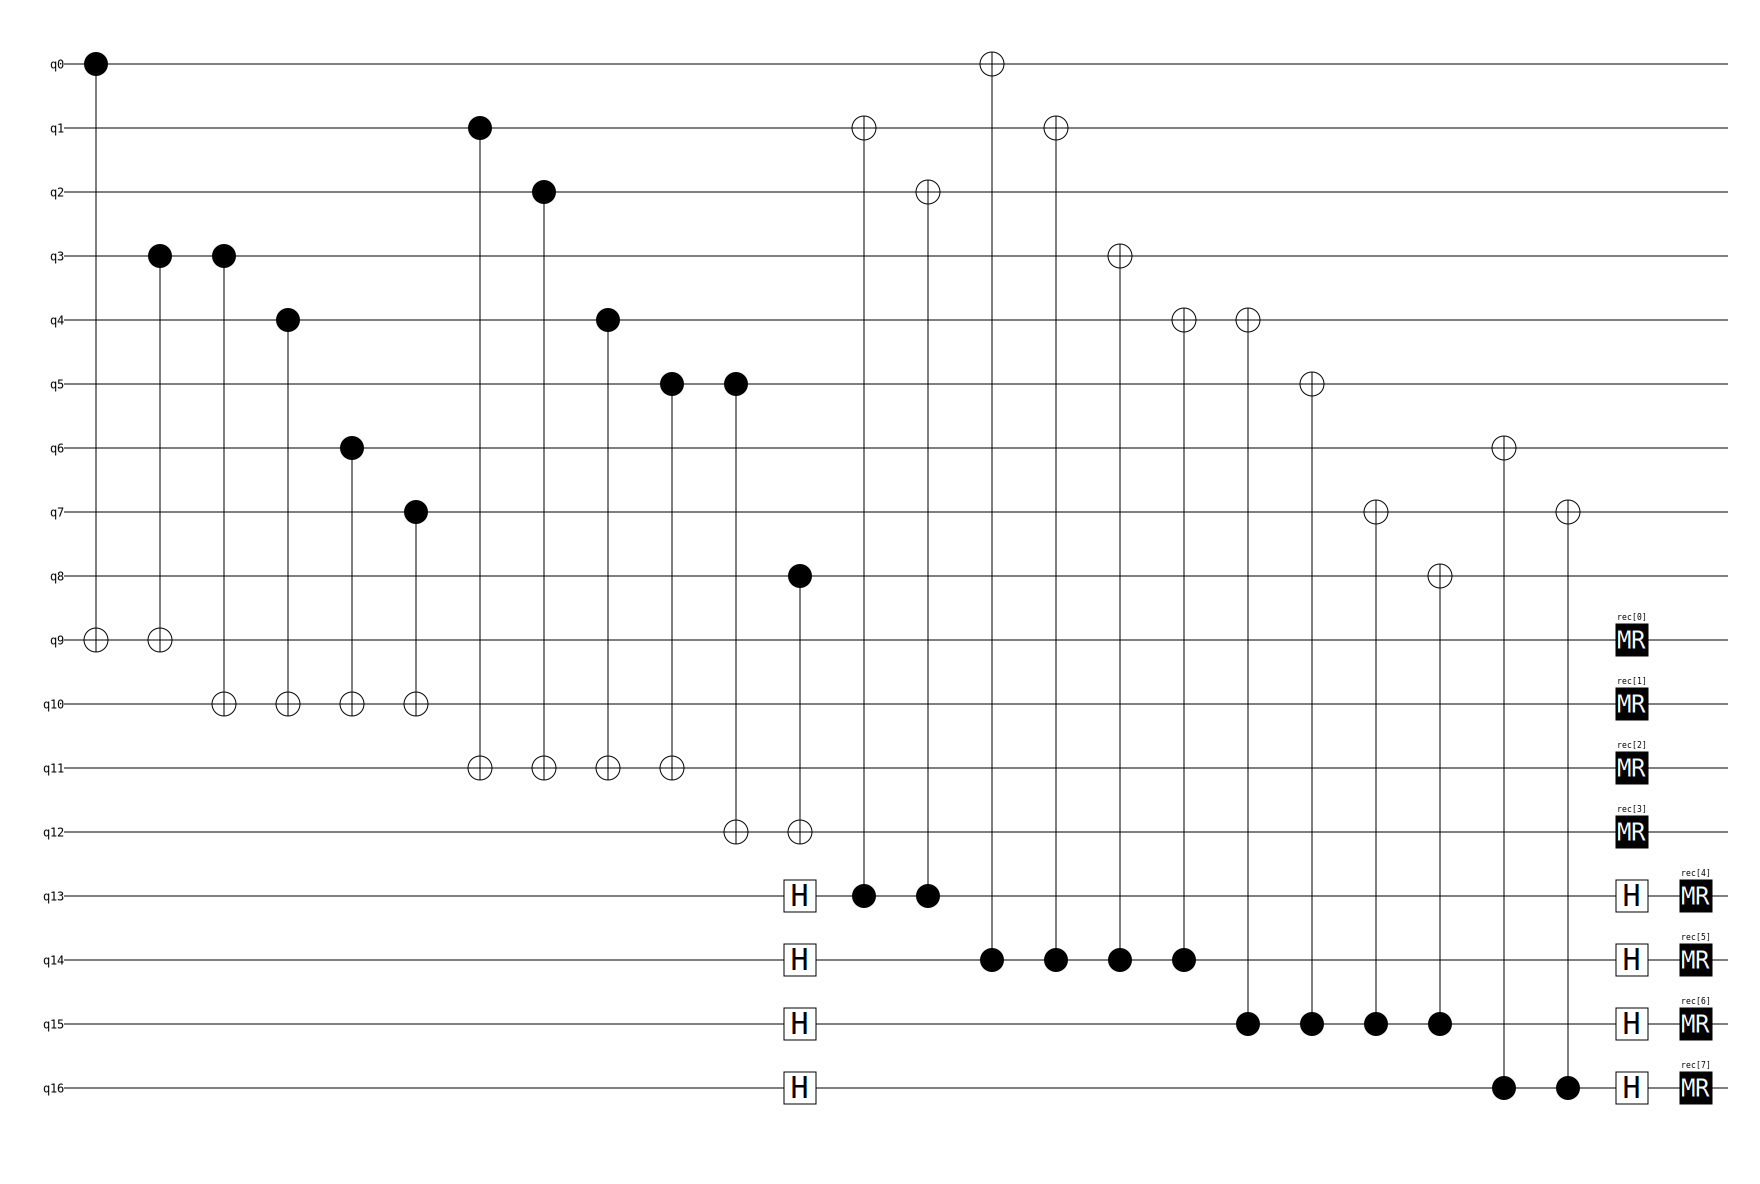

In [5]:
#We dirst define data qubits, Z-type measure qubits and X-type measure qubits
data_qubits = [0,1,2,3,4,5,6,7,8]
Z_measure_qubits = [9,10,11,12]
X_measure_qubits = [13,14,15,16]

#TASK
#We've defined the S^Z1 stabilizer here. Define all the remaining stabilzers in a similar way
Z_stabilizers = [[1,0,0,1,0,0,0,0,0],[0,0,0,1,1,0,1,1,0],[0,1,1,0,1,1,0,0,0],[0,0,0,0,0,1,0,0,1]]
X_stabilizers = [[0,1,1,0,0,0,0,0,0],[1,1,0,1,1,0,0,0,0],[0,0,0,0,1,1,0,1,1],[0,0,0,0,0,0,1,1,0]]

#Creating the stabilizer measurement circuit
surface17_Z_memory = stim.Circuit()

#TASK
#Initialize the surface-17 in a logical state. Create a quantum circuits that measures all the stabilzers.

#Z stabilizers:
for i in range(4):
    for j in np.argwhere(np.array(Z_stabilizers)[i,:] == 1).ravel():
        surface17_Z_memory.append('CNOT',[data_qubits[j],Z_measure_qubits[i]])

#X stabilizers:
surface17_Z_memory.append('H',X_measure_qubits)
for i in range(4):
    for j in np.argwhere(np.array(X_stabilizers)[i,:] == 1).ravel():
        surface17_Z_memory.append('CNOT',[X_measure_qubits[i],data_qubits[j]])
surface17_Z_memory.append('H',X_measure_qubits)

#Measurements
surface17_Z_memory.append('MR',Z_measure_qubits)
surface17_Z_memory.append('MR',X_measure_qubits)

#Visualize the circuit
surface17_Z_memory.diagram('timeline-svg')



In [ ]:
#TASK
#Now apply X-errors to all the data qubits with p=0.05 probability
p = 0.05
surface17_Z_memory.append('X_ERROR',data_qubits,p)

#TASK
#Apply the stabilizer measurement circuit again
#Z stabilizers:
for i in range(4):
    for j in np.argwhere(np.array(Z_stabilizers)[i,:] == 1).ravel():
        surface17_Z_memory.append('CNOT',[data_qubits[j],Z_measure_qubits[i]])

#X stabilizers:
surface17_Z_memory.append('H',X_measure_qubits)
for i in range(4):
    for j in np.argwhere(np.array(X_stabilizers)[i,:] == 1).ravel():
        surface17_Z_memory.append('CNOT',[X_measure_qubits[i],data_qubits[j]])
surface17_Z_memory.append('H',X_measure_qubits)

#Measurements
surface17_Z_memory.append('MR',Z_measure_qubits)
surface17_Z_memory.append('MR',X_measure_qubits)

#Finally we measure the data qubits in the Z-basis
surface17_Z_memory.append('M',data_qubits)
surface17_Z_memory.diagram("timeline-svg")

In [7]:
#Now we sample from the circuit
shots = 10
sampler = surface17_Z_memory.compile_sampler()
data = sampler.sample(shots).astype(int)
print(data)

[[0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0]
 [0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1]
 [0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0]
 [0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1]
 [0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1]
 [0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1]
 [0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1]]


# 3. Syndrome construction and decoding

In this task you construct the syndrome and a lookup table decoder to decode this syndrome.

1. Syndrome construction:

After the first round of stabilizer measurements the code is not neceseraly in the $|0_L\rangle $ state, because the measurement outcomes of the X-stabilizers are random. We can redifine some stabilizers to be -S instead of S at the positions where we measured -1. With this redefinition the syndrome is not simply the collection of stabilizer measurement outcomes, but the collection of stabilizer outcome changes from the initialization step to the first stabilizer measurement round after the errors.

Construct the X and Z syndromes as follows:

 - Collect the measurement outcome changes in two lists, one for X and one for Z. The change is defined as 0 if the consecutive measurement outcomes are the same and 1 if they are different.

Check the followings:

 - The Z syndrome list is always the same as the list of Z stabilizer measurement outcomes in the round after the errors.
 - The X syndrome list is always trivial ([0,0,0,0]) signaling the absence of Z errors.

In [8]:
#TASK
#Construct Z,X syndromes and check the statements above
Z_syndrome = (data[:,8:12]-data[:,:4])%2
X_syndrome = (data[:,12:16]-data[:,4:8])%2

print(X_syndrome)
print(Z_syndrome, data[:,8:12])

#TASK
#Construct the measurement outcome of the logical Z operator from the single data qubit measurement results
logical_Z_measurement = np.sum(np.array(data)[:,-9:],axis=1)%2

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]] [[0 0 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]]


Now you construct a decoder. Only having X-errors in the circuit means that only the Z syndrome needs to be decoded.

Construct a lookup table decoder that suggests a correction operator for every possible Z syndrome

In [9]:
#TASK
#Construct a lookup table decoder for Z syndromes by finishing the following function with the reamaining 15 Z syndromes.
def lookup_table(Z_syndrome):
    if Z_syndrome == [0,0,0,0]:
        return [0,0,0,0,0,0,0,0,0]
    elif Z_syndrome == [1,0,0,0]:
        return [1,0,0,0,0,0,0,0,0]
    elif Z_syndrome == [0,1,0,0]:
        return [0,0,0,0,0,0,1,0,0]
    elif Z_syndrome == [0,0,1,0]:
        return [0,0,1,0,0,0,0,0,0]
    elif Z_syndrome == [0,0,0,1]:
        return [0,0,0,0,0,0,0,0,1]
    elif Z_syndrome == [1,1,0,0]:
        return [0,0,0,1,0,0,0,0,0]
    elif Z_syndrome == [1,0,1,0]:
        return [1,1,0,0,0,0,0,0,0]
    elif Z_syndrome == [1,0,0,1]:
        return [1,0,0,0,0,0,0,0,1]
    elif Z_syndrome == [0,1,1,0]:
        return [0,0,0,0,1,0,0,0,0]
    elif Z_syndrome == [0,1,0,1]:
        return [0,0,0,0,0,0,0,1,1]
    elif Z_syndrome == [0,0,1,1]:
        return [0,0,0,0,0,1,0,0,0]
    elif Z_syndrome == [1,1,1,0]:
        return [1,0,0,0,1,0,0,0,0]
    elif Z_syndrome == [1,1,0,1]:
        return [0,0,0,1,0,0,0,0,1]
    elif Z_syndrome == [1,0,1,1]:
        return [1,0,0,0,0,1,0,0,0]
    elif Z_syndrome == [0,1,1,1]:
        return [0,0,0,0,1,0,0,0,1]
    elif Z_syndrome == [1,1,1,1]:
        return [0,0,0,1,0,1,0,0,0]

In [10]:
#Now we count the number of logical errors
logical_errors = 0
for i in range(shots):
    correction = lookup_table(list(Z_syndrome[i]))
    if logical_Z_measurement[i] != np.sum(np.array(correction))%2:
        logical_errors += 1
print(logical_errors)

1


# 4. Pseudo-threshold

In the following you calculate numerically the psudo-threshold of the surface-17 code. Below this specific physical error rate the logical error rate is lower than the physical error rate.

In [11]:
#TASK
#Write a function that creates the surface_17_Z_memory circuit with arbitrary physical error rate.
def create_surface17_Z_memory(p,data_qubits,Z_measure_qubits,X_measure_qubits,Z_stabilizers,X_stabilizers):
    surface17_Z_memory = stim.Circuit()
    #Z stabilizers:
    for i in range(4):
        for j in np.argwhere(np.array(Z_stabilizers)[i,:] == 1).ravel():
            surface17_Z_memory.append('CNOT',[data_qubits[j],Z_measure_qubits[i]])
    #X stabilizers:
    surface17_Z_memory.append('H',X_measure_qubits)
    for i in range(4):
        for j in np.argwhere(np.array(X_stabilizers)[i,:] == 1).ravel():
            surface17_Z_memory.append('CNOT',[X_measure_qubits[i],data_qubits[j]])
    surface17_Z_memory.append('H',X_measure_qubits)
    #Measurements
    surface17_Z_memory.append('MR',Z_measure_qubits)
    surface17_Z_memory.append('MR',X_measure_qubits)
    #Errors
    surface17_Z_memory.append('X_ERROR',data_qubits,p)
    #Z stabilizers:
    for i in range(4):
        for j in np.argwhere(np.array(Z_stabilizers)[i,:] == 1).ravel():
            surface17_Z_memory.append('CNOT',[data_qubits[j],Z_measure_qubits[i]])
    #X stabilizers:
    surface17_Z_memory.append('H',X_measure_qubits)
    for i in range(4):
        for j in np.argwhere(np.array(X_stabilizers)[i,:] == 1).ravel():
            surface17_Z_memory.append('CNOT',[X_measure_qubits[i],data_qubits[j]])
    surface17_Z_memory.append('H',X_measure_qubits)
    #Measurements
    surface17_Z_memory.append('MR',Z_measure_qubits)
    surface17_Z_memory.append('MR',X_measure_qubits)
    #Finally measure the data qubits in the Z-basis
    surface17_Z_memory.append('M',data_qubits)

    return surface17_Z_memory

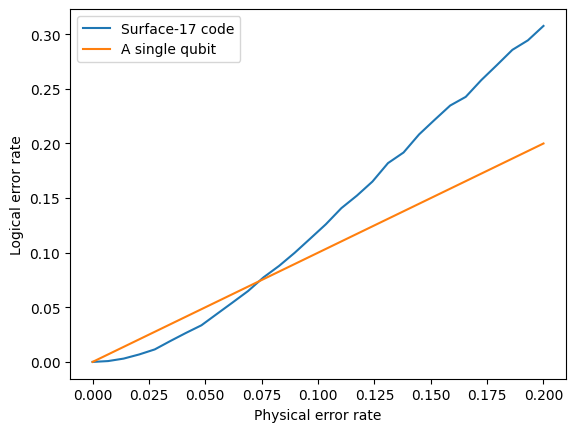

In [12]:
#TASK
#Scan over diferent values of p and plot the logical error rate as the function of p. Find the point where the logical error rate is equal to the physical error rate.
shots = 100000
L_errors = []
for p in np.linspace(0,0.2,30):
    circuit = create_surface17_Z_memory(p,data_qubits,Z_measure_qubits,X_measure_qubits,Z_stabilizers,X_stabilizers)
    sampler = circuit.compile_sampler()
    data = sampler.sample(shots).astype(int)
    Z_syndrome = (data[:,8:12]-data[:,:4])%2
    X_syndrome = (data[:,12:16]-data[:,4:8])%2
    logical_Z_measurement = np.sum(np.array(data)[:,-9:],axis=1)%2
    logical_errors = 0
    for i in range(shots):
        correction = lookup_table(list(Z_syndrome[i]))
        if logical_Z_measurement[i] != np.sum(np.array(correction))%2:
            logical_errors += 1
    L_errors.append(logical_errors/shots)

plt.plot(np.linspace(0,0.2,30),L_errors,label = "Surface-17 code")
plt.plot(np.linspace(0,0.2,30),np.linspace(0,0.2,30), label = "A single qubit")
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend(loc = 'upper left')

# 5. Larger distance surface codes

In this task you write a function that creates a distance d surface code for arbitrary d. 

We wrote the functions that create the stabilizers for a distance d surface code. You only need the inplement the circuit.


In [13]:
#Stabilizers for larger distance codes
def create_stabilizers(d):
    #X stabilizers
    X_stabilizers=np.zeros(((d**2-1)//2,d**2),dtype=int)
    counter = 0
    for i in range((d-1)//2):
        X_stabilizers[counter,1+i*2] = 1
        X_stabilizers[counter,2+2*i] = 1
        counter += 1
    for i in range(d-1):
        for j in range((d-1)//2):
            shift = i%2
            X_stabilizers[counter,shift + j*2 + i*d] = 1
            X_stabilizers[counter,shift + j*2 + i*d +1] = 1
            X_stabilizers[counter,shift + j*2 + (i+1)*d] = 1
            X_stabilizers[counter,shift + j*2 + (i+1)*d +1] = 1
            counter += 1
    for i in range((d-1)//2):
        shift = (d-1)*d
        X_stabilizers[counter,shift+i*2] = 1
        X_stabilizers[counter,shift+1+2*i] = 1
        counter += 1

    #Z stabilizers
    Z_stabilizers = np.zeros(((d**2-1)//2,d**2),dtype=int)
    counter = 0
    step = d+1
    for i in range((d-1)//2):
        Z_stabilizers[counter,(2*i)*d] = 1
        Z_stabilizers[counter,(2*i+1)*d] = 1
        counter += step
    counter = 1
    for i in range(d-1):
        shift = (i+1)%2
        for j in range((d-1)//2):
            Z_stabilizers[counter,shift + 2*j + i*d] = 1
            Z_stabilizers[counter,shift + 2*j + i*d + 1] = 1
            Z_stabilizers[counter,shift + 2*j + (i+1)*d] = 1
            Z_stabilizers[counter,shift + 2*j + (i+1)*d + 1] = 1
            counter += 1
        if i%2:
            counter += 2
    offset = (2*d)-1
    counter = step-1
    for i in range((d-1)//2):
        Z_stabilizers[counter,offset + 2*i*d] = 1
        Z_stabilizers[counter,offset + (1+2*i)*d] = 1
        counter += step
    
    return Z_stabilizers, X_stabilizers

#TASK
#Write a function that creates the surface_code_Z_memory circuit with arbitrary physical error rate and code distance. Modify the create_surface17_Z_memory function.
def create_surface_code_Z_memory(d,p,data_qubits,Z_measure_qubits,X_measure_qubits,Z_stabilizers,X_stabilizers):
    surface_code_Z_memory = stim.Circuit()
    #Z stabilizers:
    for i in range((d**2-1)//2):
        for j in np.argwhere(np.array(Z_stabilizers)[i,:] == 1).ravel():
            surface_code_Z_memory.append('CNOT',[data_qubits[j],Z_measure_qubits[i]])
    #X stabilizers:
    surface_code_Z_memory.append('H',X_measure_qubits)
    for i in range((d**2-1)//2):
        for j in np.argwhere(np.array(X_stabilizers)[i,:] == 1).ravel():
            surface_code_Z_memory.append('CNOT',[X_measure_qubits[i],data_qubits[j]])
    surface_code_Z_memory.append('H',X_measure_qubits)
    #Measurements
    surface_code_Z_memory.append('MR',Z_measure_qubits)
    surface_code_Z_memory.append('MR',X_measure_qubits)
    #Errors
    surface_code_Z_memory.append('X_ERROR',data_qubits,p)
    
    #Z stabilizers:
    for i in range((d**2-1)//2):
        for j in np.argwhere(np.array(Z_stabilizers)[i,:] == 1).ravel():
            surface_code_Z_memory.append('CNOT',[data_qubits[j],Z_measure_qubits[i]])
    #X stabilizers:
    surface_code_Z_memory.append('H',X_measure_qubits)
    for i in range((d**2-1)//2):
        for j in np.argwhere(np.array(X_stabilizers)[i,:] == 1).ravel():
            surface_code_Z_memory.append('CNOT',[X_measure_qubits[i],data_qubits[j]])
    surface_code_Z_memory.append('H',X_measure_qubits)
    #Measurements
    surface_code_Z_memory.append('MR',Z_measure_qubits)
    surface_code_Z_memory.append('MR',X_measure_qubits)
    #Finally measure the data qubits in the Z-basis
    surface_code_Z_memory.append('M',data_qubits)

    return surface_code_Z_memory

Lookup table decodig becomes hard for larger distance codes, so we are going to use minimum weight perfect matching. We will use PyMatching which is an efficient implementation of MWPM.

In [14]:
#Decoding with PyMatching
matching_graph = pymatching.Matching(Z_stabilizers)
logical_errors_pymatching = 0
for i in range(shots):
    correction = matching_graph.decode(Z_syndrome[i])
    if logical_Z_measurement[i] != np.sum(np.array(correction))%2:
        logical_errors_pymatching += 1
print(logical_errors_pymatching)

30764


# 6. Threshold

In the following you approximatelly calculate the threshold of the surface code under X-errors.

In [ ]:
#TASK
#Scan over diferent values of p and plot the logical error rate as the function of p for code distances d=3,5,7,9. Find the crossing point of the curves  
shots = 100000

full_logical_errors = []
for d in [3,5,7,9]:
    data_qubits = np.linspace(0,d**2-1,d**2,dtype = int)
    Z_measure_qubits = np.linspace(d**2, d**2 + (d**2-1)//2-1, (d**2-1)//2, dtype = int)
    X_measure_qubits = np.linspace(d**2 + (d**2-1)//2, 2*d**2-2, (d**2-1)//2, dtype = int)
    Z_stabilizers, X_stabilizers = create_stabilizers(d)

    L_errors = []
    for p in np.linspace(0,0.2,20):
        circuit = create_surface_code_Z_memory(d,p,data_qubits,Z_measure_qubits,X_measure_qubits,Z_stabilizers,X_stabilizers)
        sampler = circuit.compile_sampler()
        data = sampler.sample(shots).astype(int)
        Z_syndrome = (data[:,d**2-1 : d**2-1 + (d**2-1)//2]-data[:,:(d**2-1)//2])%2
        X_syndrome = (data[:,d**2-1 + (d**2-1)//2 : 2*d**2 - 2]-data[:,(d**2-1)//2 : d**2-1])%2
        logical_Z_measurement = np.sum(np.array(data)[:,-d**2:],axis=1)%2
        matching_graph = pymatching.Matching(Z_stabilizers)
        logical_errors = 0
        for i in range(shots):
            correction = matching_graph.decode(Z_syndrome[i])
            if logical_Z_measurement[i] != np.sum(np.array(correction))%2:
                logical_errors += 1
        L_errors.append(logical_errors/shots)
    full_logical_errors.append(L_errors)

for i in range(4):
    plt.plot(np.linspace(0,0.2,20),full_logical_errors[i],label = 'd='+str(3+2*i))
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend(loc = 'upper left')

# 7. Sub-threshold scaling

In this part you show that the surface code exponentially supresses the logical error below the threshold. To do this you need to prove that for low physical error rates the logical error rate can be written as:

$p_L(p,d) = A_d\cdot p^{(d+1)/2}$.

To investigate this you first run some simulations in the low p regime.

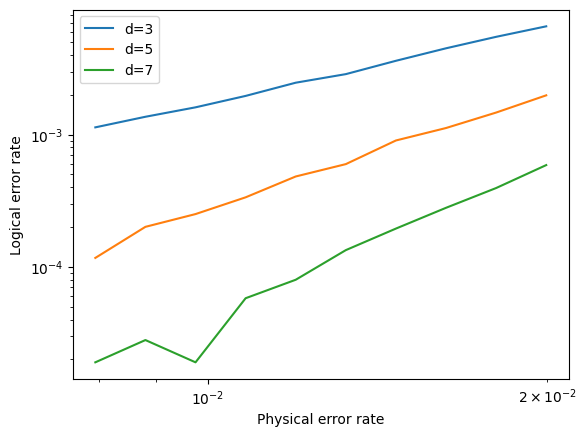

In [ ]:
#Simulations for low p and distances d=3,5,7
shots = 1000000
full_logical_errors = []
for d in [3,5,7]:
    data_qubits = np.linspace(0,d**2-1,d**2,dtype = int)
    Z_measure_qubits = np.linspace(d**2, d**2 + (d**2-1)//2-1, (d**2-1)//2, dtype = int)
    X_measure_qubits = np.linspace(d**2 + (d**2-1)//2, 2*d**2-2, (d**2-1)//2, dtype = int)
    Z_stabilizers, X_stabilizers = create_stabilizers(d)

    L_errors = []
    for p in np.logspace(-2.1,-1.7,10):
        circuit = create_surface_code_Z_memory(d,p,data_qubits,Z_measure_qubits,X_measure_qubits,Z_stabilizers,X_stabilizers)
        sampler = circuit.compile_sampler()
        data = sampler.sample(shots).astype(int)
        Z_syndrome = (data[:,d**2-1 : d**2-1 + (d**2-1)//2]-data[:,:(d**2-1)//2])%2
        X_syndrome = (data[:,d**2-1 + (d**2-1)//2 : 2*d**2 - 2]-data[:,(d**2-1)//2 : d**2-1])%2
        logical_Z_measurement = np.sum(np.array(data)[:,-d**2:],axis=1)%2
        matching_graph = pymatching.Matching(Z_stabilizers)
        logical_errors = 0
        for i in range(shots):
            correction = matching_graph.decode(Z_syndrome[i])
            if logical_Z_measurement[i] != np.sum(np.array(correction))%2:
                logical_errors += 1
        L_errors.append(logical_errors/shots)
    full_logical_errors.append(L_errors)

for i in range(3):
    plt.plot(np.logspace(-2.1,-1.7,10),full_logical_errors[i],label = 'd='+str(3+2*i))
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend(loc = 'upper left')
plt.yscale('log')
plt.xscale('log')

As you can see in the plot the curves look like exponential functions on the log-log scale

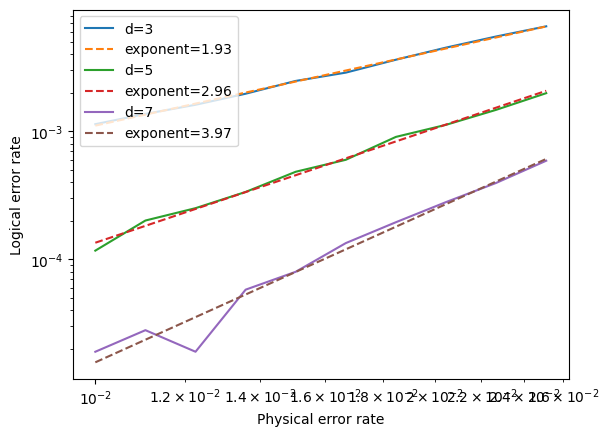

In [ ]:
from scipy.optimize import curve_fit

def linear(x,a,b):
    return a*x + b

#TASK
#Determine the exponents via a linear fit for every code distance.
logp = np.log(np.logspace(-2,-1.6,10))
logpl = np.log(np.array(full_logical_errors))

exponents = []
const = []
for i in range(3):
    popt, pcov = curve_fit(linear,logp,logpl[i,:])
    exponents.append(popt[0])
    const.append(popt[1])

for i in range(3):
    plt.plot(np.logspace(-2,-1.6,10),full_logical_errors[i],label = 'd='+str(3+2*i))
    plt.plot(np.logspace(-2,-1.6,10),np.exp(linear(logp,exponents[i],const[i])),'--',label = 'exponent=' + str(exponents[i])[:4])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend(loc = 'upper left')
plt.yscale('log')
plt.xscale('log')